In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

import scipy.io
from sklearn.feature_selection import mutual_info_regression

from tqdm import tqdm

sns.set_style("white")


# Create MLP for model training




In [ ]:
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size,
                 output_size, n_layers) -> None:
        super(PINN, self).__init__()

        layers = [("input", torch.nn.Linear(input_size, hidden_size))]
        layers.append(("input_activation", torch.nn.Tanh()))

        # For every other layer
        for i in range(n_layers):
            layers = layers + [
                (f"hidden_{i}", torch.nn.Linear(hidden_size, hidden_size)),
                (f"activation{i}", torch.nn.Tanh()),
            ]

        layers.append(("output", torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out




In [10]:
from pyDOE import lhs

lhs(2, 5)

array([[0.89476537, 0.13279978],
       [0.41727996, 0.26327866],
       [0.27108882, 0.83890967],
       [0.68199042, 0.62459283],
       [0.1550689 , 0.49113824]])

In [3]:
import scipy.io
data = scipy.io.loadmat("data/NLS.mat")
data.keys()

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Nov 10 20:10:33 2017',
 '__version__': '1.0',
 '__globals__': [],
 'tt': array([[0.        , 0.00785398, 0.01570796, 0.02356194, 0.03141593,
         0.03926991, 0.04712389, 0.05497787, 0.06283185, 0.07068583,
         0.07853982, 0.0863938 , 0.09424778, 0.10210176, 0.10995574,
         0.11780972, 0.12566371, 0.13351769, 0.14137167, 0.14922565,
         0.15707963, 0.16493361, 0.1727876 , 0.18064158, 0.18849556,
         0.19634954, 0.20420352, 0.2120575 , 0.21991149, 0.22776547,
         0.23561945, 0.24347343, 0.25132741, 0.25918139, 0.26703538,
         0.27488936, 0.28274334, 0.29059732, 0.2984513 , 0.30630528,
         0.31415927, 0.32201325, 0.32986723, 0.33772121, 0.34557519,
         0.35342917, 0.36128316, 0.36913714, 0.37699112, 0.3848451 ,
         0.39269908, 0.40055306, 0.40840704, 0.41626103, 0.42411501,
         0.43196899, 0.43982297, 0.44767695, 0.45553093, 0.46338492,
         0.4712389 , 0.4790

In [74]:

import numpy as np
# Set Seed
seed = 120
import random
#torch.random.seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

noise = 0

# Domain bounds
lb = torch.tensor([-5.0, 0.0]).float()
ub = torch.tensor([5.0, np.pi/2]).float()

N0 = 50
N_b = 50
N_f = 20000
layers = [2, 100, 2, 4]

data = scipy.io.loadmat("data/NLS.mat")

t = torch.tensor(data["tt"]).flatten()#[:, None]
x = torch.tensor(data["x"]).flatten()#[:, None]

Exact = data["uu"]
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)


X, T = torch.meshgrid(x, t, indexing = 'xy')#.reshape(2, -1) # 1D inputs required

X_star = torch.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact_u.T.flatten()[:, None]
v_star = Exact_v.T.flatten()[:, None]
h_star = Exact_h.T.flatten()[:, None]


# Initial values
idx_x = np.random.choice(x.shape[0], N0, replace = False)
x0 = x[idx_x][:, None]
u0 = Exact_u[idx_x, 0:1]
v0 = Exact_v[idx_x, 0:1]

idx_t = np.random.choice(t.shape[0], N_b, replace = False)
tb = t[idx_t][:, None]

X_f = lb + (ub-lb)*lhs(2, N_f)  # pyDOE lhs used for generating quasi-random multidimensional samples

In [81]:
torch.tensor(Exact).float()

C:\Users\iwaki\AppData\Local\Temp\ipykernel_15580\2426856432.py:1: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  C:\Users\builder\tkoch\workspace\pytorch\pytorch_1647970138273\work\aten\src\ATen\native\Copy.cpp:244.)
  torch.tensor(Exact).float()


tensor([[0.0270, 0.0283, 0.0288,  ..., 0.0267, 0.0266, 0.0264],
        [0.0280, 0.0284, 0.0289,  ..., 0.0267, 0.0265, 0.0263],
        [0.0291, 0.0289, 0.0293,  ..., 0.0267, 0.0265, 0.0263],
        ...,
        [0.0303, 0.0298, 0.0299,  ..., 0.0267, 0.0265, 0.0264],
        [0.0291, 0.0289, 0.0293,  ..., 0.0267, 0.0265, 0.0263],
        [0.0280, 0.0284, 0.0289,  ..., 0.0267, 0.0265, 0.0263]])

In [71]:

# noise = 0
# Set Seed
seed = 120
import random
#torch.random.seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Domain bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])

N0 = 50
N_b = 50
N_f = 20000
layers = [2, 100, 2, 4]

data = scipy.io.loadmat("data/NLS.mat")

t = data["tt"].flatten()[:, None]
x = data["x"].flatten()[:, None]

Exact = data["uu"]
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)


X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact_u.T.flatten()[:, None]
v_star = Exact_v.T.flatten()[:, None]
h_star = Exact_h.T.flatten()[:, None]


# Initial values
idx_x = np.random.choice(x.shape[0], N0, replace = False)
x0 = x[idx_x, :]
u0 = Exact_u[idx_x, 0:1]
v0 = Exact_v[idx_x, 0:1]

idx_t = np.random.choice(t.shape[0], N_b, replace = False)
tb = t[idx_t, :]

X_f1 = lb + (ub-lb)*lhs(2, N_f)  # pyDOE lhs used for generating quasi-random multidimensional samples

In [72]:
np.concatenate((x0, 0*x0), 1)

array([[ 2.5390625,  0.       ],
       [-0.7421875, -0.       ],
       [ 0.6640625,  0.       ],
       [-4.6484375, -0.       ],
       [-1.3671875, -0.       ],
       [-0.46875  , -0.       ],
       [ 2.6171875,  0.       ],
       [ 3.7890625,  0.       ],
       [-1.875    , -0.       ],
       [-2.0703125, -0.       ],
       [ 4.296875 ,  0.       ],
       [-3.3203125, -0.       ],
       [-2.9296875, -0.       ],
       [-4.7265625, -0.       ],
       [-4.8046875, -0.       ],
       [-3.6328125, -0.       ],
       [ 1.484375 ,  0.       ],
       [-4.9609375, -0.       ],
       [ 4.921875 ,  0.       ],
       [ 4.21875  ,  0.       ],
       [-2.421875 , -0.       ],
       [-1.015625 , -0.       ],
       [-3.75     , -0.       ],
       [-0.6640625, -0.       ],
       [ 1.6015625,  0.       ],
       [-2.5      , -0.       ],
       [ 0.8203125,  0.       ],
       [ 4.0625   ,  0.       ],
       [-3.4765625, -0.       ],
       [-0.9765625, -0.       ],
       [ 1

array([[ 2.7734375],
       [-3.2421875],
       [-0.7421875],
       [ 3.125    ],
       [-4.21875  ],
       [ 0.234375 ],
       [ 4.8828125],
       [-3.125    ],
       [ 3.1640625],
       [-0.8203125],
       [ 0.1171875],
       [ 2.734375 ],
       [-1.09375  ],
       [ 1.6796875],
       [ 3.59375  ],
       [-1.4453125],
       [ 0.3515625],
       [-4.609375 ],
       [ 4.4140625],
       [ 4.6484375],
       [ 2.96875  ],
       [-3.046875 ],
       [ 2.8125   ],
       [ 2.6953125],
       [ 1.4453125],
       [ 4.21875  ],
       [-0.4296875],
       [-1.2109375],
       [ 4.53125  ],
       [-1.953125 ],
       [-2.6953125],
       [-4.921875 ],
       [-4.140625 ],
       [ 4.765625 ],
       [-4.2578125],
       [ 0.625    ],
       [ 3.359375 ],
       [-0.2734375],
       [-0.0390625],
       [-1.484375 ],
       [-2.6171875],
       [ 2.109375 ],
       [ 0.78125  ],
       [-4.453125 ],
       [ 2.03125  ],
       [-1.5625   ],
       [-1.328125 ],
       [-4.68

In [ ]:
class ModelNetwork:
    def __init__(self) -> None:

        self.model = PINN(input_size=2, hidden_size=20,
                          output_size=1, n_layers=4)

        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)

        # exact solution
        self.X = torch.stack(torch.meshgrid(x, t, indexing = 'ij')).reshape(2, -1).T

        # training data such that it fits Burger's equation along with Dirichlet boundary conditions
        # https://maziarraissi.github.io/PINNs/#:~:text=Example%20(Burgers%E2%80%99%20Equation)
        
        bc1 = torch.stack(torch.meshgrid(x[0], t, indexing = 'ij')).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t, indexing = 'ij')).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0], indexing = 'ij')).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X.requires_grad = True
        
        # Defime training parameters
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr = 1,
            max_iter = 5e4,
            max_eval= 5e4,
            history_size=50,
            tolerance_change=1.0 * np.finfo(float).eps,
            tolerance_grad=1e-5
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())
        
    def loss_func(self): 
        """
        Define loss functions describing physics of the system
        """
        # https://maziarraissi.github.io/PINNs/#:~:text=The%20shared%20parameters%20between,mean%20squared%20error%20loss
        
        self.optimizer.zero_grad()
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        
        u = self.model(self.X)
        
        du_dX = torch.autograd.grad(inputs =self.X, outputs = u,grad_outputs=  torch.ones_like(u),
                                    retain_graph=True, create_graph=True)[0]
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(inputs =self.X, outputs = du_dX, grad_outputs=  torch.ones_like(du_dX),
                                    retain_graph=True, create_graph=True)[0][:, 0]
        
        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, 0.01 /math.pi * du_dxx)
        
        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 100 == 0:
            print(self.iter ,  loss.item())
        self.iter = self.iter + 1
        
        return loss
    
    def train(self, epochs):
        for i in range(epochs):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
            
            

In [6]:

net = ModelNetwork()
net.train(100)



100 0.13070806860923767
200 0.04985522851347923
300 0.014318806119263172
400 0.00944647565484047
500 0.006226564757525921
600 0.004161141812801361
700 0.0032879896461963654
800 0.0023331111297011375
900 0.0017453692853450775
1000 0.0014307036763057113
1100 0.0011535737430676818
1200 0.0009945605415850878
1300 0.0008318639011122286
1400 0.0007229842012748122
1500 0.0005911734770052135
1600 0.0004893250297755003
1700 0.00044398856698535383
1800 0.00039420704706571996
1900 0.00033044538577087224
2000 0.00029483885737136006
2100 0.00027245565433986485
2200 0.00024923437740653753
2300 0.0002194952394347638
2400 0.00019861827604472637
2500 0.0001791832037270069
2600 0.00016832626715768129
2700 0.00016036439046729356
2800 0.0001530753797851503
2900 0.00014382480003405362
3000 0.0001375069550704211
3100 0.00013325741747394204
3200 0.00012715710909105837
3300 0.00012377684470266104
3400 0.00011801111395470798
3500 0.0001117111969506368
3600 0.00010583079711068422
3700 0.0001011482672765851
3800

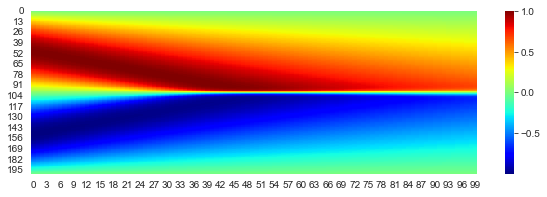

In [10]:
# Evaluating model

h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# Exact solution = 
X = torch.stack(torch.meshgrid(x, t, indexing = 'ij')).reshape(2, -1).T
plt.figure(figsize = (10, 3))
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).numpy()
    
sns.heatmap(y_pred, cmap = "jet")
plt.savefig("heatmap.png")
        
        